# Multi-armed bandits

In [ ]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod



## Media recommendation 
In this notebook, the problem of choosing articles to recommend to users on a news website is considered. The articles correspond to actions and clicks correspond to rewards (assumed to be {0, 1}-valued). The per round cumulative reward corresponds to the click-through-rate (CTR), which is exactly what news services want to maximise to drive user engagement and advertising revenue.


### Implementation details
Here, epsilon-greedy MAB is implemented as classes which derive from a common base class `BaseMAB` defined in the code block below.

There are only two public methods:
* `play`: use this to pull an arm
* `update`: use this to update the internal state of the MAB based on the reward received

Only a small amount of logic is implemented in `BaseMAB`.
It sets the number of arms; initialises an array for recording the number of pulls of each arm; and does some basic input checking.

In [ ]:
class BaseMAB(ABC):
    """
    Base class for a multi-armed bandit (MAB)

    Parameters
    ----------
    n_arms : int
        Number of arms

    Attributes
    ----------
    n_pulls : numpy.ndarray, shape=(n_arms,)
        Number of pulls for each arm
    """
    def __init__(self, n_arms):
        if not isinstance(n_arms, (int, np.integer)):
            raise TypeError("`n_arms` must be an int")
        if n_arms <= 0:
            raise ValueError("`n_arms` must be positive")
        self.n_arms = n_arms
        self.n_pulls = np.zeros(n_arms, dtype=int)

    @abstractmethod
    def play(self):
        """
        Play a round

        Returns
        -------
        arm : int
            A positive integer arm id in {0, ..., n_arms - 1}
        """
        pass

    @abstractmethod
    def update(self, arm, reward):
        """
        Updates the internal state of the MAB after playing a round

        Parameters
        ----------
        arm : int
            A positive integer arm id in {0, ..., n_arms - 1}

        reward : float
            Reward received from arm
        """
        if not isinstance(arm, (int, np.integer)):
            raise TypeError("`arm` must be an int")
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range [0, {}]".format(self.n_arms - 1))
        if not isinstance(reward, (int, np.integer, float, np.float64)):
            raise TypeError("`reward` must be a numeric scalar")

***
## Epsilon-greedy strategy

In [ ]:
def argmax_rand(x):
    """
    Argmax with ties broken uniformly at random

    Parameters
    ----------
    x : 1d numpy.ndarray
        Input array

    Returns
    -------
    argmax : int
        Integer index of the max value in x
    """
    # fill in
    return np.random.choice(np.flatnonzero(x == x.max()))
#     return np.argmax(x)

In [ ]:
class EpsGreedy(BaseMAB):
    """
    Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability in interval [0, 1]

    Q0 : float, optional
        Initial value for the arms

    Attributes
    ----------
    n_pulls : numpy.ndarray, shape=(narms,)
        Number of pulls for each arm

    mean_rewards : numpy.ndarray, shape=(narms,)
        Mean reward per arm
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.epsilon = float(epsilon)
        self.Q0 = float(Q0)
        if self.epsilon < 0 or self.epsilon > 1:
            raise ValueError("`epsilon` must be in the interval [0, 1]")
        self.mean_rewards = np.full(n_arms, self.Q0)

    def play(self):
        super().play()
        # fill in
#         if random.random() < self.epsilon:
        if np.random.binomial(1, self.epsilon):
            # Explore
            return np.random.randint(0, self.n_arms)
        else:
            # Exploit
            return argmax_rand(self.mean_rewards)

    def update(self, arm, reward):
        super().update(arm, reward)
        # fill in
        n = self.n_pulls[arm]
        if n > 0:
            self.mean_rewards[arm] = (self.mean_rewards[arm] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm] = reward
        self.n_pulls[arm] += 1


## Upper Confidence Bound

In [ ]:
class UCB(BaseMAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, c, Q0=np.inf):
        super().__init__(n_arms)
        if not np.issubdtype(type(c), np.floating):
            raise TypeError("`c` must be a float")
        if c <= 0:
            raise ValueError("`c` must be positive")
        if not np.issubdtype(type(Q0), np.floating):
            raise ValueError("`Q0` must be a float")

        self.c = c
        self.Q0 = Q0
        self.n_pulls = np.zeros(n_arms)
        self.mean_rewards = np.full(n_arms, self.Q0)
        self.Q_values = np.copy(self.mean_rewards)
        self.n_rounds = 0

    def play(self):
        super().play()
        return argmax_rand(self.Q_values)

    def update(self, arm, reward):
        super().update(arm, reward)

        # Online update of mean rewards
        n = self.n_pulls[arm]
        if n > 0:
            self.mean_rewards[arm] = (self.mean_rewards[arm] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm] = reward
        self.n_pulls[arm] += 1

        # Update Q-values
        self.Q_values[:] = self.mean_rewards
        # Add on UCB for arms that have been pulled at least once
        pulled_prev = self.n_pulls > 0
        self.Q_values[pulled_prev] += np.sqrt(self.c * np.log(self.n_rounds + 1) / self.n_pulls[pulled_prev])
        self.n_rounds += 1


## Offline evaluation

In [ ]:
def offlineEvaluate(mab, arms, rewards, n_rounds=None):
    """
    Offline evaluation of a multi-armed bandit

    Parameters
    ----------
    mab : instance of MAB
        Multi-armed bandit strategy to evaluate

    arms : int numpy.ndarray, shape (n_events,)
        Sequence of randomly selected arm ids (events)

    rewards : float numpy.ndarray, shape (n_events,)
        Sequence of rewards received for each event

    n_rounds : int, optional
        Number of matching events to evaluate `mab` on.

    Returns
    -------
    out : 1D float array
        Rewards for the matching events.
    """
    if not isinstance(mab, BaseMAB):
        raise TypeError("`mab` must be an instance of BaseMAB")

    if not isinstance(arms, np.ndarray):
        raise TypeError("`arms` must be a numpy.ndarray")
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1d array")
    arms = arms.astype(int)
    if np.setdiff1d(np.unique(arms), np.arange(mab.n_arms)).size != 0:
        raise ValueError("`arms` contains values not in [0,...,n_arms-1]")

    if not isinstance(rewards, np.ndarray):
        raise TypeError("`rewards` must be a numpy.ndarray")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1d array")
    if arms.shape != rewards.shape:
        raise ValueError("`arms` and `rewards` must have the same shape")
    rewards = rewards.astype(float)
#     rewards = np.float64(rewards)

    if n_rounds is not None:
        n_rounds = int(n_rounds)
        if n_rounds < 0:
            raise ValueError("`n_rounds` must be non-negative")

    matched_ctr = 0
    matched_rewards = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds:
            break
        arm = mab.play()
        if arm == arms[i]:
            mab.update(arm, rewards[i])
            matched_ctr += 1
            matched_rewards.append(rewards[i])
    return np.array(matched_rewards)

Let's now load a historical data set.
It corresponds to a bandit problem with $K = 10$ arms (news articles).
There are 10,000 uniformly-random arm pulls along with the observed rewards.
The 10-dimensional context vector for each arm (modelling article/user features) is discarded here.

In [ ]:
# Load event log from a bandit run
dataset = np.genfromtxt('dataset.txt.gz', dtype=np.int64)
arms = dataset[:,0] - 1
rewards = dataset[:,1].astype(float)
# contexts = dataset[:,2::].astype(float).reshape(-1,10,10) (don't need contexts)

Evaluate the epsilon-greedy strategy and UCB strategy on this data set. We set $\epsilon = 0.01$ for epsilon-greedy and $c=1.0$ for UCB

In [ ]:
epsgreedy_mab = EpsGreedy(10, epsilon=0.01,Q0=10)
results_EpsGreedy = offlineEvaluate(epsgreedy_mab, arms, rewards, n_rounds=800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.19


In [ ]:
ucb_mab = UCB(10, c=1.0)
results_UCB = offlineEvaluate(ucb_mab, arms, rewards, n_rounds=800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17625


Let's plot the running average cumulative reward v.s. round

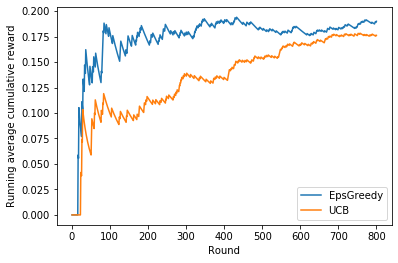

In [ ]:
for mab in ['EpsGreedy', 'UCB']:
    results = eval('results_' + mab)
    t_round = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results) / t_round
    plt.plot(t_round, cumsum, label=mab)
plt.legend()
plt.xlabel('Round')
plt.ylabel('Running average cumulative reward')
plt.show()